In [1]:
import os
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cuda'


In [2]:
from PIL import Image
import numpy as np
import tarfile

# 下載 dataset
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
import os
import urllib
from urllib.request import urlretrieve
def reporthook(a,b,c):
    print("\rdownloading: %5.1f%%"%(a*b*100.0/c), end="")
tar_gz = "cifar-10-python.tar.gz"
if not os.path.isfile(tar_gz):
        print('Downloading data from %s' % url)
        urlretrieve(url, tar_gz, reporthook=reporthook)

import pickle
train_X=[]
train_y=[]
tar_gz = "cifar-10-python.tar.gz"
with tarfile.open(tar_gz) as tarf:
    for i in range(1, 6):
        dataset = "cifar-10-batches-py/data_batch_%d"%i
        print("load",dataset)
        with tarf.extractfile(dataset) as f:
            result = pickle.load(f, encoding='latin1')
        train_X.extend( result['data'].reshape(-1,3,32,32)/255*2-1)
        train_y.extend(result['labels'])
    train_X=np.float32(train_X)
    train_y=np.int32(train_y)
    dataset = "cifar-10-batches-py/test_batch"
    print("load",dataset)
    with tarf.extractfile(dataset) as f:
        result = pickle.load(f, encoding='latin1')
        test_X=np.float32(result['data'].reshape(-1,3,32,32)/255*2-1)
        test_y=np.int32(result['labels'])
train_X = np.concatenate([train_X, test_X])
train_X = np.concatenate([train_X[:,:,:,::-1], train_X])

load cifar-10-batches-py/data_batch_1
load cifar-10-batches-py/data_batch_2
load cifar-10-batches-py/data_batch_3
load cifar-10-batches-py/data_batch_4
load cifar-10-batches-py/data_batch_5
load cifar-10-batches-py/test_batch


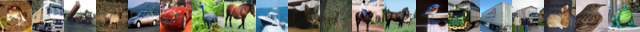

[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]
['青蛙' '卡車' '卡車' '鹿' '汽車' '汽車' '鳥' '馬' '船' '貓' '鹿' '馬' '馬' '鳥' '卡車' '卡車'
 '卡車' '貓' '鳥' '青蛙']


In [3]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    int_X = np.moveaxis(int_X, 1, 3)
    int_X_reshape = int_X.reshape(rows, -1, 32, 32,3).swapaxes(1,2).reshape(rows*32,-1, 3)
    display(Image.fromarray(int_X_reshape))
# 訓練資料， X 的前 20 筆
showX(train_X[:20])
print(train_y[:20])
name_array = np.array("飛機、汽車、鳥、貓、鹿、狗、青蛙、馬、船、卡車".split('、'))
print(name_array[train_y[:20]])

In [4]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import DenseLayer, DropoutLayer, ReshapeLayer, InputLayer, FlattenLayer, Upscale2DLayer, LocalResponseNormalization2DLayer
floatX = theano.config.floatX
from lasagne.layers import MaxPool2DLayer, Conv2DLayer, TransposedConv2DLayer
from lasagne.layers import batch_norm

Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [5]:
conv_init = lasagne.init.Normal(0.02, 0)
gamma_init = lasagne.init.Normal(0.02, 1)

In [6]:
def DCGAN_D(isize, nz, nc, ndf, n_extra_layers=0):
    _ = InputLayer(shape=(None, nc, isize, isize))
    _ = Conv2DLayer(_, num_filters=ndf, filter_size=4, stride=2, pad=1, b=None, W=conv_init, flip_filters=False,
               name = 'initial.conv.{0}-{1}'.format(nc, ndf), 
                nonlinearity=lasagne.nonlinearities.LeakyRectify(0.2))
    csize, cndf = isize // 2, ndf
    while csize > 5:
        in_feat = cndf
        out_feat = cndf*2
        _ = Conv2DLayer(_, num_filters=out_feat, filter_size=4, stride=2, pad=1, b=None, W=conv_init, 
                                   flip_filters=False,
               name = 'pyramid.{0}-{1}.conv'.format(in_feat, out_feat), 
                nonlinearity=lasagne.nonlinearities.LeakyRectify(0.2))
        _ = batch_norm(_, epsilon=1e-5)
        csize, cndf = csize//2, cndf*2
        
    _ = Conv2DLayer(_, num_filters=1, filter_size=csize, stride=1, pad=0, b=None, W=conv_init, 
                    flip_filters=False,
               name = 'final.{0}-{1}.conv'.format(cndf, 1), 
                nonlinearity=None)
    _ = FlattenLayer(_)
    return _


In [7]:
def DCGAN_G(isize, nz, nc, ngf, n_extra_layers=0):
    cngf= ngf//2
    tisize = isize
    while tisize > 5:
        cngf = cngf * 2
        tisize = tisize // 2
    _ = InputLayer(shape=(None, nz))
    _ = ReshapeLayer(_, (-1, nz, 1,1))
    _ = TransposedConv2DLayer(_, num_filters=cngf, filter_size=tisize, stride=1, crop=0, b=None, 
                              W=conv_init,
               name =  'initial.{0}-{1}.convt'.format(nz, cngf))
    _ = batch_norm(_, epsilon=1e-5)
    csize, cndf = tisize, cngf
    
    while csize < isize//2:
        in_feat = cngf
        out_feat = cngf//2
        _ = TransposedConv2DLayer(_, num_filters=out_feat, filter_size=4, stride=2, crop=1, b=None, W=conv_init,
               name = 'pyramid.{0}-{1}.convt'.format(in_feat, out_feat))
        _ = batch_norm(_, epsilon=1e-5)
        csize, cngf = csize*2, cngf//2
    _ = TransposedConv2DLayer(_, num_filters=nc, filter_size=4, stride=2, crop=1, b=None, W=conv_init,
               name = 'final.{0}-{1}.convt'.format(cngf, nc), nonlinearity=lasagne.nonlinearities.tanh)       
    return _


In [8]:
nc = 3
nz = 100
ngf = 64
ndf = 64
n_extra_layers = 0
Diters = 5

imageSize = 32
batchSize = 64
lrD = 0.00005*10
lrG = 0.00005*10
clamp_lower, clamp_upper = -0.01, 0.01

In [9]:
netD = DCGAN_D(imageSize, nz, nc, ndf, n_extra_layers)
for l in lasagne.layers.get_all_layers(netD):
    print(l.name,  l.output_shape)

None (None, 3, 32, 32)
initial.conv.3-64 (None, 64, 16, 16)
pyramid.64-128.conv (None, 128, 8, 8)
pyramid.64-128.conv_bn (None, 128, 8, 8)
pyramid.64-128.conv_bn_nonlin (None, 128, 8, 8)
pyramid.128-256.conv (None, 256, 4, 4)
pyramid.128-256.conv_bn (None, 256, 4, 4)
pyramid.128-256.conv_bn_nonlin (None, 256, 4, 4)
final.256-1.conv (None, 1, 1, 1)
None (None, 1)


In [10]:
netG = DCGAN_G(imageSize, nz, nc, ngf, n_extra_layers)
for l in lasagne.layers.get_all_layers(netG):
    print(l.name,  l.output_shape)

None (None, 100)
None (None, 100, 1, 1)
initial.100-256.convt (None, 256, 4, 4)
initial.100-256.convt_bn (None, 256, 4, 4)
initial.100-256.convt_bn_nonlin (None, 256, 4, 4)
pyramid.256-128.convt (None, 128, 8, 8)
pyramid.256-128.convt_bn (None, 128, 8, 8)
pyramid.256-128.convt_bn_nonlin (None, 128, 8, 8)
pyramid.128-64.convt (None, 64, 16, 16)
pyramid.128-64.convt_bn (None, 64, 16, 16)
pyramid.128-64.convt_bn_nonlin (None, 64, 16, 16)
final.64-3.convt (None, 3, 32, 32)


In [11]:
input_var_D = lasagne.layers.get_all_layers(netD)[0].input_var
input_var_G = lasagne.layers.get_all_layers(netG)[0].input_var

In [12]:
no_bn_avg = dict(       batch_norm_update_averages=False,
                       batch_norm_use_averages=False)
output_D = lasagne.layers.get_output(netD, **no_bn_avg)
output_G = lasagne.layers.get_output(netG, **no_bn_avg)

output_D_fake = lasagne.layers.get_output(netD, inputs=output_G, **no_bn_avg)

loss_D_real = output_D.mean()
loss_D_fake = output_D_fake.mean()
loss_D = loss_D_fake - loss_D_real
loss_G = -loss_D_fake


params_netD = lasagne.layers.get_all_params(netD, trainable=True) 
params_netG = lasagne.layers.get_all_params(netG, trainable=True)
optimize_G = lasagne.updates.rmsprop(loss_G, params_netG, learning_rate=lrG)
optimize_D = lasagne.updates.rmsprop(loss_D, params_netD, learning_rate=lrD)
train_G_fn =  theano.function([input_var_G], [loss_G], updates=optimize_G)
train_D_fn = theano.function([input_var_D, input_var_G], [loss_D, loss_D_real, loss_D_fake], 
                                         updates=optimize_D)

generator_fn = theano.function([input_var_G], output_G)
clamp_D_fn = theano.function([], [], updates = [(w, T.clip(w, clamp_lower, clamp_upper)) for w in params_netD])

In [13]:
fixed_noise = np.random.normal(size=(batchSize, nz)).astype('float32')

[2/1000][1100/1875][500] Loss_D: -0.336256 Loss_G: 0.280765 Loss_D_real: 0.283048 Loss_D_fake -0.053208 61.76538372039795


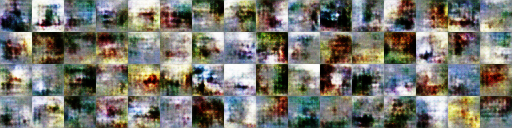

[3/1000][1820/1875][1000] Loss_D: -0.191440 Loss_G: 0.162243 Loss_D_real: 0.169954 Loss_D_fake -0.021486 96.13531756401062


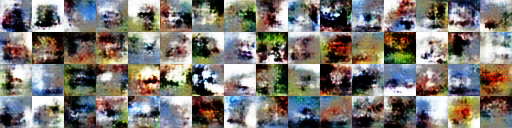

[5/1000][620/1875][1500] Loss_D: -0.171216 Loss_G: 0.080680 Loss_D_real: 0.110375 Loss_D_fake -0.060841 130.94056034088135


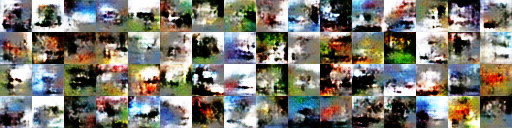

[6/1000][1340/1875][2000] Loss_D: -0.161707 Loss_G: 0.143996 Loss_D_real: 0.091119 Loss_D_fake -0.070589 165.2372751235962


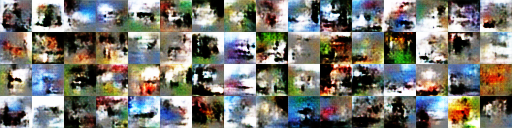

[8/1000][185/1875][2500] Loss_D: -0.057816 Loss_G: -0.046895 Loss_D_real: -0.147600 Loss_D_fake -0.205416 200.82776260375977


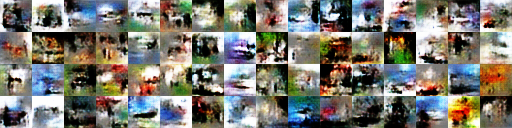

[9/1000][905/1875][3000] Loss_D: -0.126685 Loss_G: -0.003757 Loss_D_real: 0.051178 Loss_D_fake -0.075507 235.25290656089783


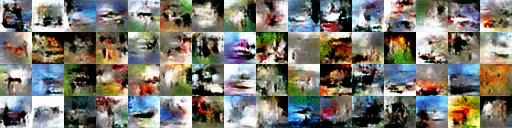

[10/1000][1625/1875][3500] Loss_D: -0.122266 Loss_G: 0.068517 Loss_D_real: 0.052604 Loss_D_fake -0.069662 269.69472575187683


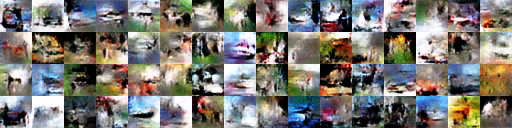

[12/1000][470/1875][4000] Loss_D: -0.107115 Loss_G: 0.041206 Loss_D_real: 0.039032 Loss_D_fake -0.068083 304.03209686279297


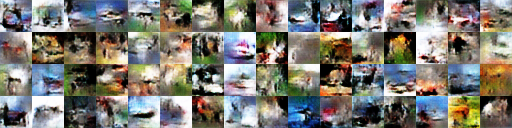

[13/1000][1190/1875][4500] Loss_D: -0.079673 Loss_G: 0.108478 Loss_D_real: 0.074975 Loss_D_fake -0.004699 337.83522772789


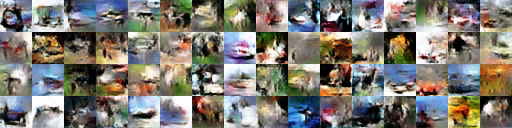

[15/1000][35/1875][5000] Loss_D: -0.054841 Loss_G: 0.117508 Loss_D_real: 0.064771 Loss_D_fake 0.009930 372.41721057891846


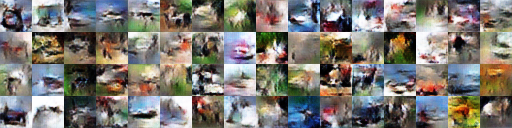

[16/1000][755/1875][5500] Loss_D: -0.047372 Loss_G: -0.062144 Loss_D_real: -0.064114 Loss_D_fake -0.111486 407.15809965133667


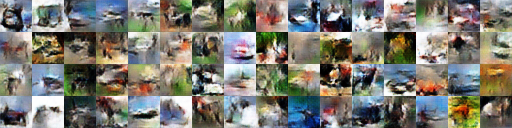

[17/1000][1475/1875][6000] Loss_D: -0.022516 Loss_G: -0.005627 Loss_D_real: 0.017960 Loss_D_fake -0.004556 441.11031126976013


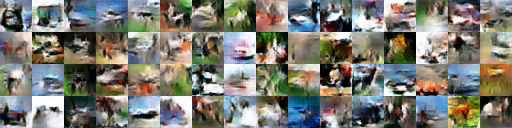

[19/1000][320/1875][6500] Loss_D: -0.005705 Loss_G: -0.030465 Loss_D_real: 0.036060 Loss_D_fake 0.030354 475.9282319545746


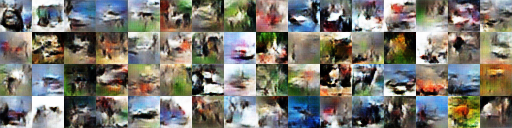

[20/1000][1040/1875][7000] Loss_D: -0.007685 Loss_G: 0.016823 Loss_D_real: -0.012887 Loss_D_fake -0.020572 509.87177872657776


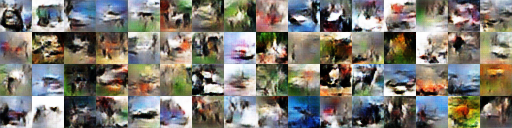

[21/1000][1760/1875][7500] Loss_D: -0.001595 Loss_G: -0.013412 Loss_D_real: 0.008758 Loss_D_fake 0.007164 544.1484670639038


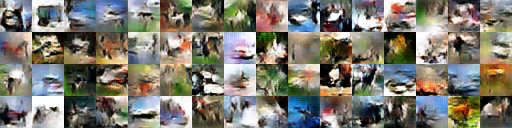

[23/1000][605/1875][8000] Loss_D: -0.003823 Loss_G: 0.003475 Loss_D_real: -0.000232 Loss_D_fake -0.004055 578.5374777317047


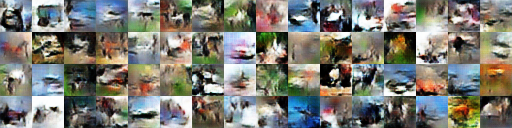

[24/1000][1325/1875][8500] Loss_D: -0.004751 Loss_G: -0.007052 Loss_D_real: 0.005219 Loss_D_fake 0.000468 612.2104206085205


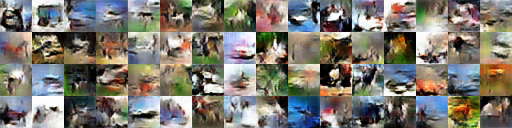

[26/1000][170/1875][9000] Loss_D: 0.001316 Loss_G: -0.001477 Loss_D_real: -0.002041 Loss_D_fake -0.000725 646.4623246192932


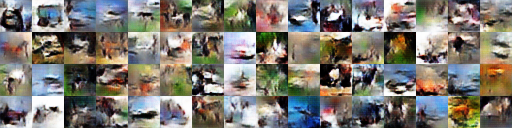

[27/1000][890/1875][9500] Loss_D: -0.001238 Loss_G: -0.004042 Loss_D_real: 0.004542 Loss_D_fake 0.003304 681.7209899425507


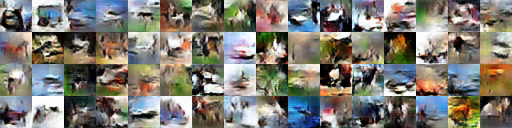

[28/1000][1610/1875][10000] Loss_D: -0.007992 Loss_G: 0.013228 Loss_D_real: -0.010867 Loss_D_fake -0.018859 716.9152998924255


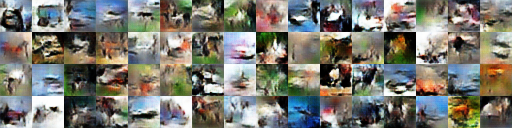

KeyboardInterrupt: 

In [14]:
import time
t0 = time.time()
niter = 1000
gen_iterations = 0
for epoch in range(niter):
    i = 0
    #  每個 epoch 洗牌一下
    np.random.shuffle(train_X)
    batches = train_X.shape[0]//batchSize
    while i < batches:
        if gen_iterations < 25 or gen_iterations %500 == 0:
            _Diters = 100
        else:
            _Diters = Diters
        j = 0
        while j < _Diters and i < batches:
            j+=1       
            clamp_D_fn()
            real_data = train_X[i*batchSize:(i+1)*batchSize]
            i+=1        
            noise  = np.random.normal(size=(batchSize, nz)).astype('float32')
            errD, errD_real, errD_fake = train_D_fn(real_data, noise)
        noise = np.random.normal(size=(batchSize, nz)).astype('float32')        
        errG = train_G_fn(noise)[0]
        gen_iterations+=1
        if gen_iterations%500==0:
            print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f'
            % (epoch, niter, i, batches, gen_iterations,
            errD, errG, errD_real, errD_fake), time.time()-t0)
        if gen_iterations%500 == 0:            
            fake = generator_fn(fixed_noise)
            showX(fake, 4)
        